Analyzing Media Coverage Of Other Countries in Austria
===


The aim of this project is to find out how reporting in Austria's print media about certain countries has changed over time (sentiment, which topics). In two further steps, I would also like to go down to the level of the individual newspapers and their authors and take an explorative look at whether there are tendencies/bias here. As countries of interest I choose Balkan countries because of their proximity to Austria and their long history of conflict.

    Text corpora: Austrian newspaper articles (or their respective twitter posts)
    Language: German
    Time: 2000–2022
    Method: Adding country labels to the articles, Sentiment Scores (, extracting underlying topics of the articles, e.g. with fuzzy topic modeling) 
    
According to https://de.wikipedia.org/wiki/Liste_%C3%B6sterreichischer_Zeitungen_und_Zeitschriften derstandard.at and krone.at reach the most people online, they also cover Austrian society quite well. So, initially, I will focus on these two and might add some more newspapers at a later stage.

* Focus on 2 countries: Serbia and Croatia (like Austria now a EU country)
* I will label an article with "Serbia" if the ratio of amount of words that relate to "Serbia"  compared to words that relate to "Croatia" is greater than 4
* I will also try to find out if there are certain authors who are responsible for a certain tendency.
* Another analysis could be build upon the ratio of "Serbia" and "Albania" or "Kosovo"

**Hypothesis 1: Tweets about Croatia are on average more positive than tweets about Serbia**

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from bs4 import BeautifulSoup
import requests


data_dir = "data/twitter"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def dl_user(user, max_results=None, local=False):
    """
    Function to download tweets by username.
    Set local to True, if tweets have already
    been downloaded and are available in data_dir.

    Returns a DataFrame.

    """

    if local == False:
        with open(data_dir + f"/user-{user}.json", "w+") as fo:
            if max_results == None:
                cmd_list = ["snscrape", "--jsonl", "twitter-user", user]
            else:
                cmd_list = [
                    "snscrape",
                    "--jsonl",
                    "-n " + str(max_results),
                    "twitter-user",
                    user,
                ]
            p = subprocess.Popen(cmd_list, stdout=fo)
            p.wait()

    with open(data_dir + f"/user-{user}.json", "r") as fo:
        tweets = fo.readlines()

    tweets = [json.loads(tweets[i]) for i in range(0, len(tweets))]
    print("loaded", len(tweets), "tweets\n")

    df_tweets = pd.DataFrame(tweets)
    df_tweets["date"] = pd.to_datetime(df_tweets["date"])

    return df_tweets

# 1. Scraping newspaper articles

## 1.1. derStandard.at


In [3]:
df_tweets = dl_user("derstandardat", max_results=None, local=True)


df_tweets[["date", "rawContent", "hashtags"]].head()

loaded 272281 tweets



,date,rawContent,hashtags
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,None
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",None
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",None
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",None
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,None


### Extract urls for complete articles

<div class="alert alert-warning">Takes ages! Speed this up!!!</div>

In [ ]:
def get_direct_url(txt):
    """
    Redirect.
    
    """
    
    try:
        url = re.search(
            "(?P<url>https?://[^\s]+)", txt).captures()[0]
    except:
        url = ""
    
    url_direct = None
    
    if url != "":
        while url_direct == None:
            try:
                page = requests.get(url)
                html = BeautifulSoup(page.text, "html.parser")
                url_direct = html.find("link")
                if url_direct == None:
                    url_direct = ""
                else:
                    url_direct = url_direct.get("href")
            except Exception as e:
                print(e)
    else:
        return url

    return url_direct


df_tweets["news_url"] = df_tweets["rawContent"].apply(lambda x: get_direct_url(x))
df_tweets.to_csv(data_dir + "/media_coverage_with_url.csv", index=False)

### Compute sentiment scores for all tweets

In [47]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)
df_tweets["sentiment_vader"] = df_tweets.rawContent.apply(
    lambda x: sid.polarity_scores(x)["compound"]
)

### Which hashtags are most often used by this user

In [48]:
len_nohashtags = sum(pd.isna(df_tweets.hashtags))
len_nohashtags

260302

In [49]:
hashtags = list(df_tweets.hashtags.dropna())

In [50]:
len(hashtags)

11979

In [51]:
hashtags[623]

['Bundespressedienst']

In [52]:
hashtags_flat = [item for sublist in hashtags for item in sublist]

len(hashtags_flat)

15147

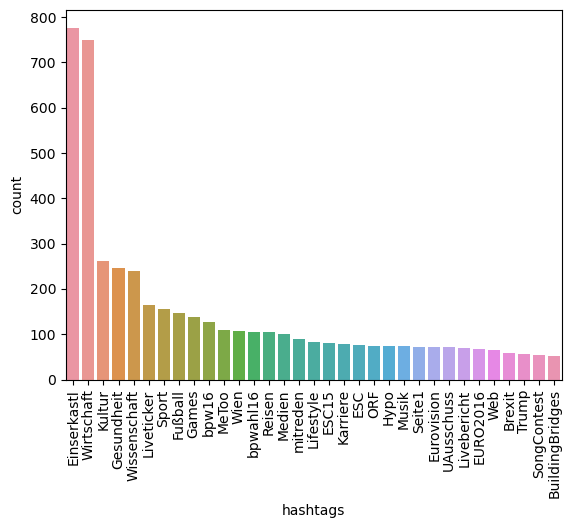

In [53]:
df_hashtags = pd.concat(
    [
        pd.DataFrame(hashtags_flat, columns=["hashtags"]),
        df_tweets.loc[pd.isna(df_tweets.hashtags), ["hashtags"]],
    ],
    sort=False,
).astype(str)

df_hashtags["count"] = 1
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .count()
    .sort_values("count", ascending=False)
    .reset_index()
)

# all the ones tha occur only few times and label them as "other" and group again
df_hashtags.loc[df_hashtags["count"] <= 50, "hashtags"] = "other"
df_hashtags = (
    df_hashtags.groupby(["hashtags"])
    .sum()
    .sort_values("count", ascending=False)
    .reset_index()
)

# drop the first 2 most frequently hashtags (None, other)
sns.barplot(x="hashtags", y="count", data=df_hashtags.drop(0, axis=0).drop(1, axis=0))
plt.xticks(rotation=90);

### Which countries are the tweets referring to (Serbia, Croatia)?

In [54]:
countries = dict(
    serbia=["serbien", "serbe", "serbin", "serbisch", "serbo"],
    croatia=["kroatien", "kroate", "kroatin", "kroatisch", "kroato"],
    romania=["rumänien", "rumäne", "rumänin", "rumänisch"],
    hungary=["ungarn", "ungar", "ungarin", "ungarisch", "ungaro"],
    finland=["finnland", "finne", "finnin", "finnisch", "finno"],
    norway=["norwegen", "norweger", "norwegisch"],
    sweden=["schweden", "schwedin", "schwedisch"],
    danmark=["dänisch", "dänen", "dänin", "dänisch"],
    poland=["polen", "pole", "polin", "polnisch"],
    bulgaria=["bulgarien", "bulgare", "bulgarin", "bulgarisch"],
    russia=["russland", "russe", "russin", "russen", "russisch"],
    ukraine=["ukraine", "ukrainisch"],
    germany=["deutschland", "deutsche"],
    frankreich=["frankreich", "franzose", "französi"],
    slovenia=["slowenien", "slowene", "sloweni"],
    italy=["italien"],
    spain=["spanien", "spanier", "spanisch"],
    portugal=["portual", "portugiese", "portugiesin", "portugiesisch"],
    switzerland=["schweiz"],
    austria=["österreich"],
    slovakia=["slowakei", "slowake", "slowakin", "slowakisch"],
    czechia=["tschechien", "tscheche", "tschechin", "tschechisch"],
    belarus=[
        "belarus",
        "weißrussland",
        "weissrussland",
        "weißrussisch",
        "weissrussisch",
        "weißrusse",
        "weissrusse",
        "weißrussin",
        "weissrussin",
    ],
    bosnia=["bosnien", "bosnisch", "herzegowina", "bosnier", "herzegowinisch"],
    montenegro=["montenegro", "montenegriner", "montenegrinisch"],
    albania=["albanien", "albaner", "albanisch"],
)

#### Function for finding tweets about countries

In [132]:
def get_country(df_tweets, country, not_country=None, and_country=None):
    """

    Filters DataFrame with tweets to country-
    specific tweets.

    Optional: Can exclude tweeds of specific other countries
    via not_country variable.

    """

    df_country = df_tweets[
        ["date", "rawContent", "news_url", "sentiment_vader", "sentiment_textblob"]
    ].copy()

    if not_country != None:

        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
            & ~df_country.rawContent.str.lower().str.contains(
                "|".join(not_country), regex=True
            )
        ].reset_index(drop=True)

    else:
        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
        ].reset_index(drop=True)

    return df_country

### Compare sentiments betweens countries

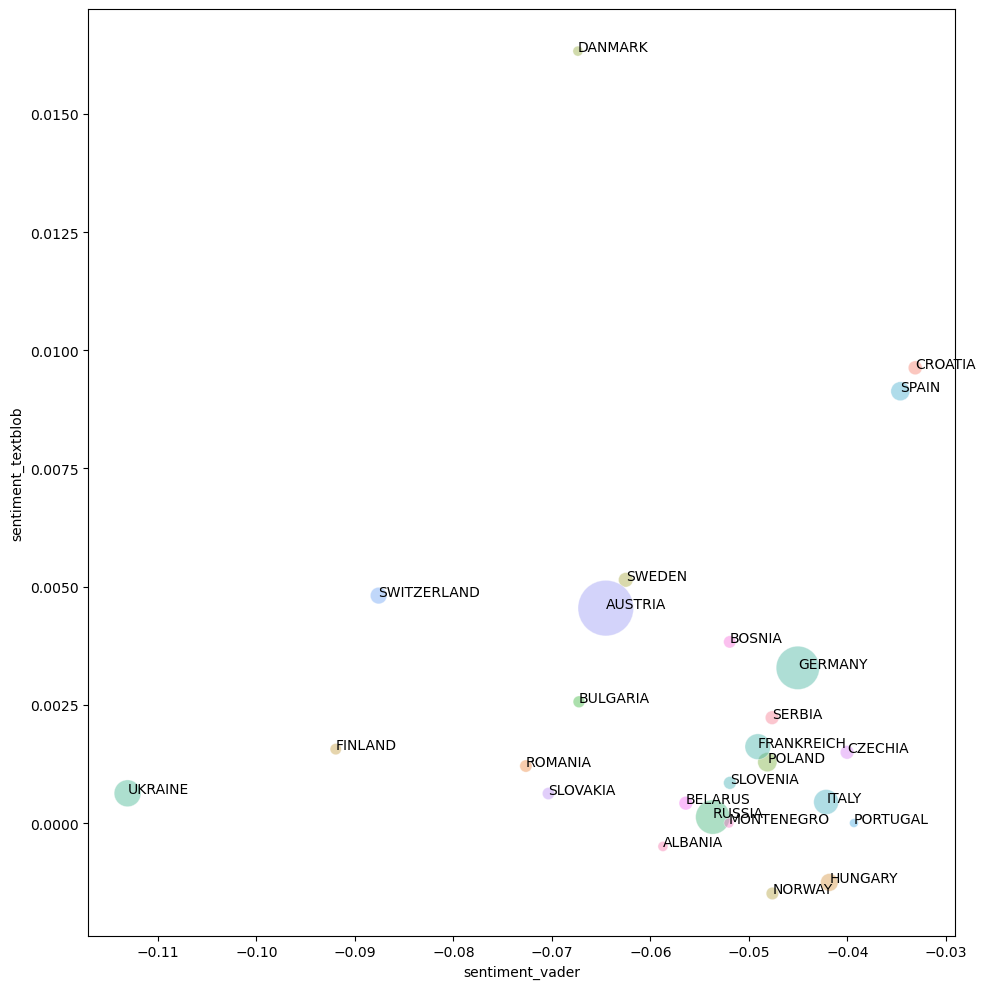

In [133]:
df_scores = pd.DataFrame()

for key in countries.keys():
    df_scores_tmp = get_country(df_tweets, countries[key])[
        ["sentiment_vader", "sentiment_textblob"]
    ]
    count = len(df_scores_tmp)
    df_scores_tmp = pd.DataFrame(
        df_scores_tmp.mean(),
        columns=[key],
    ).T
    df_scores_tmp["count"] = count
    df_scores = pd.concat([df_scores, df_scores_tmp], sort=False)

df_scores = df_scores.reset_index().rename(columns={"index": "country"})

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_scores,
    x="sentiment_vader",
    y="sentiment_textblob",
    hue="country",
    size="count",
    sizes=(40, 1600),
    legend=False,
    alpha=0.4,
)

for tup in df_scores.itertuples():
    plt.annotate(tup[1].upper(), (tup[2], tup[3]))

plt.tight_layout()

#### Find tweets about Serbia (but not Croatia)

In [ ]:
df_serbien = get_country(df_tweets, countries["serbia"], countries["croatia"])


df_serbien.head()

#### Find tweets about Croatia (but not Serbia)

In [ ]:
df_kroatien = get_country(df_tweets, countries["croatia"], countries["serbia"])


df_kroatien.head()

#### Find tweets about both Serbia and Croatia

In [ ]:
df_both = df_tweets[
    ["date", "rawContent", "sentiment_vader", "sentiment_textblob"]
].copy()

df_both = df_both.loc[
    df_both.rawContent.str.lower().str.contains(
        "|".join(countries["croatia"]), regex=True
    )
    & df_both.rawContent.str.lower().str.contains(
        "|".join(countries["serbia"]), regex=True
    )
].reset_index(drop=True)


print(len(df_both), "tweets")


df_both.head()

#### Controls: Find tweets about other countries (Romania, Hungary, Finland)

In [ ]:
df_rumanien = get_country(df_tweets, countries["romania"])


df_rumanien.head()

In [ ]:
df_ungarn = get_country(df_tweets, countries["hungary"])


df_ungarn.head()

In [ ]:
df_finnland = get_country(df_tweets, countries["finland"])


df_finnland.head()

In [ ]:
from scipy.stats import ttest_ind
from pingouin import ttest

*t*-Test

In [ ]:
ttest(
    df_kroatien.sentiment_textblob, df_serbien.sentiment_textblob, alternative="greater"
)

Permutation test

In [ ]:
ttest_ind(
    df_kroatien.sentiment_textblob,
    df_serbien.sentiment_textblob,
    permutations=100_000,
    alternative="greater",
)

<div class="alert alert-info">More positive coverage of Croatia over Serbia is significant, but the difference is small.</div>

*t*-Tests vs baseline

In [ ]:
df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)

df_tweets.sentiment_textblob.mean()

In [ ]:
ttest_ind(df_kroatien.sentiment_textblob, df_tweets.sentiment_textblob)

In [ ]:
ttest_ind(df_serbien.sentiment_textblob, df_tweets.sentiment_textblob)

### Scrape the complete articles

In [ ]:
uoi = df_serbien.news_url[0]
uoi

In [ ]:
# Find all li tag
datas = soup.find_all("li")
 
# Iterate through all li tags
for data in datas:
    # Get text from each tag
    print(data.text)
 
print(f"Total {len(datas)} li tag found")